In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ShallowNetwork

# Test for RMSE

Let's test if the written shallow network class works for a simple case of fitting it to the cosine function with the RMSE loss function.

In [2]:
X = np.arange(0, 2 * np.pi, 0.03)
X = X.reshape((X.shape[0], 1, 1))
Y = np.sin(X)

## Definining loss functions

In [3]:
def loss_function_single_point(self, point, ground_truth):
        N = self.forward_pass(point, 0)
        loss = np.sqrt(((N - ground_truth) ** 2).sum())
        return loss

In [4]:
def loss_function_all(self, samples, labels):
        loss = 0
        n_inv = len(samples) ** -1
        for i in range(samples.shape[0]):
            loss += self.loss_function_single_point(self, samples[i], labels[i]) ** 2
        loss *= n_inv
        loss = np.sqrt(loss)
        return loss

## Defining the update rules

In [5]:
def bias_change_point(self, point, label):
  db = np.zeros((self.hidden_dim, 1)).astype(dtype="float64")
  change = self.forward_pass(point, 0) - label
  loss = self.loss_function_single_point(self, point, label)
  db_N = self.network_derivative_bias(point, 0)
  for m in range(self.hidden_dim):
    for j in range(self.visible_dim):
      db[m] += change[j] * db_N[j, 0, m]
  db /= loss
  return db

In [6]:
def hidden_weights_change_point(self, point, label):
  dH = np.zeros((self.hidden_dim, self.input_dim)).astype(dtype="float64")
  change = self.forward_pass(point, 0) - label
  loss = self.loss_function_single_point(self, point, label)
  dH_N = self.network_derivative_hidden_weights(point, 0)
  for m in range(self.hidden_dim):
    for p in range(self.input_dim):
      for j in range(self.visible_dim):
        dH[m, p] += change[j] * dH_N[j, 0, m, p]
  dH /= loss
  return dH

In [7]:
def visible_weights_change_point(self, point, label):
  dV = np.zeros((self.visible_dim, self.hidden_dim)).astype(dtype="float64")
  change = self.forward_pass(point, 0) - label
  loss = self.loss_function_single_point(self, point, label)
  dV_N = self.network_derivative_visible_weights(point, 0)
  for m in range(self.visible_dim):
    for p in range(self.hidden_dim):
      for j in range(self.visible_dim):
        dV[m, p] += change[j] * dV_N[j, 0, m, p]
  dV /= loss
  return dV

## Defining the netowork for the task

In [8]:
network = ShallowNetwork.ShallowNetwork(loss_function=loss_function_all,
                                        loss_function_single_point=loss_function_single_point,
                                       bias_change=bias_change_point,
                                       hidden_weights_change=hidden_weights_change_point,
                                       visible_weights_change=visible_weights_change_point,
                                       hidden_dim=50, unsupervised=False, momentum=0, learning_rate=0.1)

In [9]:
network.train(samples=X, labels=Y, epochs=10)

Epoch: 1 Loss function: 1.455663928971233
Epoch: 2 Loss function: 0.5188670065789509
Epoch: 3 Loss function: 0.48341567094040266
Epoch: 4 Loss function: 0.3369823755050468
Epoch: 5 Loss function: 0.4616042618537419
Epoch: 6 Loss function: 0.7983873995643652
Epoch: 7 Loss function: 0.271004329583058
Epoch: 8 Loss function: 0.28322646475978314
Epoch: 9 Loss function: 0.38866982289359964
Epoch: 10 Loss function: 0.36118477245241903


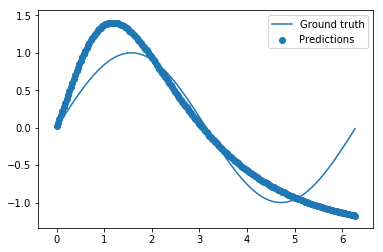

In [10]:
Y2 = np.array([network.forward_pass(X[i], 0) for i in range(X.shape[0])])
Xp = X.reshape((X.shape[0],))
Yp = Y.reshape((Y.shape[0],))
plt.plot(Xp, Yp, label='Ground truth')
plt.scatter(Xp, Y2, label='Predictions')
plt.legend()
plt.show() 

## Trial Solution class

In [11]:
class Trial_Solution:
  def __init__(self, loss_function, loss_function_single_point,
               bias_change, hidden_weights_change, visible_weights_change,
               boundary_condition_value_function, boundary_vanishing_function,
               input_dim=1, hidden_dim=1, output_dim=1, momentum=0, learning_rate=0.1):
    # Dimensions of the Shallow Network
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim
    
    # Defining all of the three parts of the trial solution f(X)=A(X)+B(X)N(X)
    # A(X) is a function fullfiling the boundary or initial conditions
    self.boundary_condition_value_function = boundary_condition_value_function
    # B(X) is a function vanishing on the boundary or in the initial moment
    self.boundary_vanishing_function = boundary_vanishing_function
    # N(X) is the Shallow Network
    self.network = ShallowNetwork.ShallowNetwork(
      input_dim=self.input_dim, hidden_dim=self.hidden_dim, visible_dim=self.output_dim,
      momentum=momentum, learning_rate=learning_rate, loss_function=loss_function,
      loss_function_single_point=loss_function_single_point, bias_change=bias_change,
      hidden_weights_change=hidden_weights_change, visible_weights_change=visible_weights_change,
      unsupervised=True)

  def predict(self, X):
    return self.boundary_condition_value_function(X) + self.boundary_vanishing_function(X) * self.network.forward_pass(X, 0)
    
  def train(self, samples, epochs):
    self.network.train(samples=samples, epochs=epochs, labels=None)

## Example 1

$\frac{d}{dx}\Psi+(x+\frac{1+3x^2}{1+x+x^3})\Psi=x^3+2x+x^2\frac{1+3x^2}{1+x+x^3}$

With boundary initial condition $\Psi(0)=1$ and domain $x\in[0,1]$

In [12]:
Xe1 = np.arange(0,1,0.1).reshape((10,1,1)) + 1e-6

In [14]:
def example1_initial_value(point):
  return 1

In [15]:
def example1_boundary_vanishing(point):
  return point

In [16]:
def example1_loss_function_single_point(self, point, non_squared=False, *kwargs):
  N = self.forward_pass(point, 0)
  dN = self.forward_pass(point, 1)
  loss = (
      point * dN + N + (point + (1 + 3 * point ** 2)/(1 + point + point ** 3)) * (1 + point * N) 
      - point ** 3 - 2 * point - (1 + 3 * point ** 2)/(1 + point + point ** 3)
    )
  if not non_squared:
    loss = loss ** 2
  return loss[0,0]

In [17]:
def example1_loss_function(self, samples, *kwargs):
  loss = 0
  for i in range(samples.shape[0]):
    loss += self.loss_function_single_point(self, samples[i])
  return loss/samples.shape[0]

In [18]:
def example1_bias_change(self, point, label, *kwargs):
  db = np.zeros((self.hidden_dim, 1)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  db_N = self.network_derivative_bias(point, 0)
  db_DN = self.network_derivative_bias(point, 1)
  point = point.reshape((1,))
  for m in range(self.hidden_dim):
    db[m] += 2 * loss_sqrt * (
      point * db_DN[0, 0, m] + db_N[0, 0, m] + (point + (1 + 3 * point ** 2)/(1 + point + point ** 3)) * point * db_N[0, 0, m])
  return db

In [19]:
def example1_hidden_weights_change(self, point, *kwargs):
  dH = np.zeros((self.hidden_dim, self.input_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  dH_N = self.network_derivative_hidden_weights(point, 0)
  dH_DN = self.network_derivative_hidden_weights(point, 1)
  for m in range(self.hidden_dim):
    for p in range(self.input_dim):
      dH[m, p] += 2 * loss_sqrt * (
        point * dH_DN[0, 0, m, p] + dH_N[0, 0, m, p] + (point + (1 + 3 * point ** 2)/(1 + point + point ** 3)) * point * dH_N[0, 0, m, p])
  return dH

In [20]:
def example1_visible_weights_change(self, point, *kwargs):
  dV = np.zeros((self.visible_dim, self.hidden_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  dV_N = self.network_derivative_visible_weights(point, 0)
  dV_DN = self.network_derivative_visible_weights(point, 1)
  for m in range(self.visible_dim):
    for p in range(self.hidden_dim):
      dV[m, p] += 2 * loss_sqrt * (
        point * dV_DN[0, 0, m, p] + dV_N[0, 0, m, p] + (point + (1 + 3 * point ** 2)/(1 + point + point ** 3)) * point * dV_N[0, 0, m, p])
  return dV

In [34]:
example1_trial_solution = Trial_Solution(loss_function=example1_loss_function,
                                        loss_function_single_point=example1_loss_function_single_point,
                                        bias_change=example1_bias_change,
                                        hidden_weights_change=example1_hidden_weights_change,
                                        visible_weights_change=example1_visible_weights_change,
                                        boundary_condition_value_function=example1_initial_value,
                                        boundary_vanishing_function=example1_boundary_vanishing,
                                        input_dim=1, hidden_dim=20, output_dim=1, learning_rate=1e-1)

In [35]:
example1_trial_solution.train(Xe1, 2000)

Epoch: 1 Loss function: 0.03478253355532551
Epoch: 2 Loss function: 0.00896673364907489
Epoch: 3 Loss function: 0.006222929966460873
Epoch: 4 Loss function: 0.09971299239925466
Epoch: 5 Loss function: 0.0026632962394032996
Epoch: 6 Loss function: 0.0011697509339650307
Epoch: 7 Loss function: 0.0015125339442728187
Epoch: 8 Loss function: 0.00210120179601534
Epoch: 9 Loss function: 0.0015618919589666955
Epoch: 10 Loss function: 0.015163348115299163
Epoch: 11 Loss function: 0.0010848073728379332
Epoch: 12 Loss function: 0.0018394390328716815
Epoch: 13 Loss function: 0.00612596524022168
Epoch: 14 Loss function: 0.0017649207804506253
Epoch: 15 Loss function: 0.001437071402297473
Epoch: 16 Loss function: 0.010044033784619696
Epoch: 17 Loss function: 0.00952136497644022
Epoch: 18 Loss function: 0.0010124600918951167
Epoch: 19 Loss function: 0.003234627084552968
Epoch: 20 Loss function: 0.016915920825841074
Epoch: 21 Loss function: 0.0013729458912410074
Epoch: 22 Loss function: 0.0221923491351

Epoch: 177 Loss function: 0.0012001962971382816
Epoch: 178 Loss function: 0.0013213419714793273
Epoch: 179 Loss function: 0.001258839124550159
Epoch: 180 Loss function: 0.000914232336714346
Epoch: 181 Loss function: 0.0016996543763796671
Epoch: 182 Loss function: 0.0012689085432564878
Epoch: 183 Loss function: 0.00095551039595149
Epoch: 184 Loss function: 0.0009219366668152418
Epoch: 185 Loss function: 0.0013873107305054813
Epoch: 186 Loss function: 0.0010477692398947942
Epoch: 187 Loss function: 0.0024314126733022126
Epoch: 188 Loss function: 0.0009111076014167569
Epoch: 189 Loss function: 0.0009104263562037702
Epoch: 190 Loss function: 0.0011453158529930827
Epoch: 191 Loss function: 0.0013123229661456649
Epoch: 192 Loss function: 0.0015358300004851952
Epoch: 193 Loss function: 0.000981359545981424
Epoch: 194 Loss function: 0.0009112611339999333
Epoch: 195 Loss function: 0.0009426828391737041
Epoch: 196 Loss function: 0.0024040332421029027
Epoch: 197 Loss function: 0.00091213710440416

Epoch: 350 Loss function: 0.0015077289327037596
Epoch: 351 Loss function: 0.0008939185440599417
Epoch: 352 Loss function: 0.0019825077321199568
Epoch: 353 Loss function: 0.001958861500958334
Epoch: 354 Loss function: 0.001014555416761078
Epoch: 355 Loss function: 0.0008855156885441727
Epoch: 356 Loss function: 0.0008781393852689285
Epoch: 357 Loss function: 0.001278144262857645
Epoch: 358 Loss function: 0.001369754961079949
Epoch: 359 Loss function: 0.0013670303183825924
Epoch: 360 Loss function: 0.0008859257966812488
Epoch: 361 Loss function: 0.001900120956431607
Epoch: 362 Loss function: 0.000880515538887961
Epoch: 363 Loss function: 0.002405048203459374
Epoch: 364 Loss function: 0.0010625842627352139
Epoch: 365 Loss function: 0.0010623159297393882
Epoch: 366 Loss function: 0.0008887217443649554
Epoch: 367 Loss function: 0.0008958031110869187
Epoch: 368 Loss function: 0.0011361727133579126
Epoch: 369 Loss function: 0.000907975934038648
Epoch: 370 Loss function: 0.001062158633317298
E

Epoch: 549 Loss function: 0.0008845383664220424
Epoch: 550 Loss function: 0.0010331610129715842
Epoch: 551 Loss function: 0.0008459395307186637
Epoch: 552 Loss function: 0.0018331980335938372
Epoch: 553 Loss function: 0.0008571060868204307
Epoch: 554 Loss function: 0.0008563838778700608
Epoch: 555 Loss function: 0.0010721570779154096
Epoch: 556 Loss function: 0.0010506239634302296
Epoch: 557 Loss function: 0.0012926388591262584
Epoch: 558 Loss function: 0.0013983611499190796
Epoch: 559 Loss function: 0.0008875707539797555
Epoch: 560 Loss function: 0.000910684258194616
Epoch: 561 Loss function: 0.0010975531746545838
Epoch: 562 Loss function: 0.0008647320116495272
Epoch: 563 Loss function: 0.0011967719629118016
Epoch: 564 Loss function: 0.001853511489225516
Epoch: 565 Loss function: 0.0018237906152693117
Epoch: 566 Loss function: 0.0010673610916678723
Epoch: 567 Loss function: 0.0010490007964938115
Epoch: 568 Loss function: 0.0009072037651023997
Epoch: 569 Loss function: 0.00084384046682

Epoch: 774 Loss function: 0.0017523743219426985
Epoch: 775 Loss function: 0.0017752737715573182
Epoch: 776 Loss function: 0.0008255104158195442
Epoch: 777 Loss function: 0.0008312896308937421
Epoch: 778 Loss function: 0.0009821598931090362
Epoch: 779 Loss function: 0.0008382943087395011
Epoch: 780 Loss function: 0.0008519083568264959
Epoch: 781 Loss function: 0.000832213603710723
Epoch: 782 Loss function: 0.0010445491787104502
Epoch: 783 Loss function: 0.0008118567964110225
Epoch: 784 Loss function: 0.000861656601965601
Epoch: 785 Loss function: 0.001865786175069693
Epoch: 786 Loss function: 0.0011002336557530631
Epoch: 787 Loss function: 0.0010286614727764414
Epoch: 788 Loss function: 0.0008221296839789414
Epoch: 789 Loss function: 0.0008252262861946684
Epoch: 790 Loss function: 0.0015371122760418673
Epoch: 791 Loss function: 0.0012813443100896695
Epoch: 792 Loss function: 0.0008268107506337623
Epoch: 793 Loss function: 0.0008363299499862496
Epoch: 794 Loss function: 0.001063665092533

Epoch: 1011 Loss function: 0.0007878108843939787
Epoch: 1012 Loss function: 0.00208247968187576
Epoch: 1013 Loss function: 0.0008039227841151093
Epoch: 1014 Loss function: 0.0007845941502700648
Epoch: 1015 Loss function: 0.0010106054494905285
Epoch: 1016 Loss function: 0.0007813913588913971
Epoch: 1017 Loss function: 0.0008605864091914221
Epoch: 1018 Loss function: 0.0007905187258266568
Epoch: 1019 Loss function: 0.0007966854052124987
Epoch: 1020 Loss function: 0.0008161602320405148
Epoch: 1021 Loss function: 0.0017868939825873343
Epoch: 1022 Loss function: 0.0007815173479865101
Epoch: 1023 Loss function: 0.0009081910115687703
Epoch: 1024 Loss function: 0.0008063625781438054
Epoch: 1025 Loss function: 0.0008329118126034448
Epoch: 1026 Loss function: 0.001089490418150351
Epoch: 1027 Loss function: 0.0007783631270791034
Epoch: 1028 Loss function: 0.0008254387539338059
Epoch: 1029 Loss function: 0.0007887904199827664
Epoch: 1030 Loss function: 0.0007776626011723643
Epoch: 1031 Loss functi

Epoch: 1182 Loss function: 0.000763090192998163
Epoch: 1183 Loss function: 0.0007941842346057225
Epoch: 1184 Loss function: 0.0008987780058527572
Epoch: 1185 Loss function: 0.0009146003751841563
Epoch: 1186 Loss function: 0.00165300205090771
Epoch: 1187 Loss function: 0.0007841762571237424
Epoch: 1188 Loss function: 0.0011936403427198921
Epoch: 1189 Loss function: 0.001661830527813507
Epoch: 1190 Loss function: 0.000782136106028505
Epoch: 1191 Loss function: 0.0007855128355555302
Epoch: 1192 Loss function: 0.0016965512548007167
Epoch: 1193 Loss function: 0.0009079576965001078
Epoch: 1194 Loss function: 0.0007994018370523062
Epoch: 1195 Loss function: 0.0008341432662537099
Epoch: 1196 Loss function: 0.0008240260635400369
Epoch: 1197 Loss function: 0.0010317011982030949
Epoch: 1198 Loss function: 0.0016672546872634828
Epoch: 1199 Loss function: 0.000862696937843492
Epoch: 1200 Loss function: 0.0007540113044400019
Epoch: 1201 Loss function: 0.0009256657900035947
Epoch: 1202 Loss function:

Epoch: 1351 Loss function: 0.0007855476021155994
Epoch: 1352 Loss function: 0.0012177194851754902
Epoch: 1353 Loss function: 0.0007422684275124703
Epoch: 1354 Loss function: 0.0007765931768909556
Epoch: 1355 Loss function: 0.0008423596270866684
Epoch: 1356 Loss function: 0.0009077775799098343
Epoch: 1357 Loss function: 0.0007451414121024793
Epoch: 1358 Loss function: 0.0010556804592272166
Epoch: 1359 Loss function: 0.0008966031236286772
Epoch: 1360 Loss function: 0.0008354437011533404
Epoch: 1361 Loss function: 0.0007429611111250785
Epoch: 1362 Loss function: 0.0009648407740910608
Epoch: 1363 Loss function: 0.001843737531092732
Epoch: 1364 Loss function: 0.0010527015076096566
Epoch: 1365 Loss function: 0.0009895350426981833
Epoch: 1366 Loss function: 0.0007313234937488553
Epoch: 1367 Loss function: 0.0009754792071381919
Epoch: 1368 Loss function: 0.0007367153932670595
Epoch: 1369 Loss function: 0.0007323185567243734
Epoch: 1370 Loss function: 0.0007864580827287016
Epoch: 1371 Loss func

Epoch: 1518 Loss function: 0.0011087482729875895
Epoch: 1519 Loss function: 0.0007210958550449742
Epoch: 1520 Loss function: 0.0008748139986924939
Epoch: 1521 Loss function: 0.0009773327366530235
Epoch: 1522 Loss function: 0.0015206220027768323
Epoch: 1523 Loss function: 0.0007724106501737771
Epoch: 1524 Loss function: 0.000776608770452232
Epoch: 1525 Loss function: 0.0007958473764716617
Epoch: 1526 Loss function: 0.0007156939442078319
Epoch: 1527 Loss function: 0.0008193869090704958
Epoch: 1528 Loss function: 0.0010841530977497623
Epoch: 1529 Loss function: 0.0010116284485404351
Epoch: 1530 Loss function: 0.0007181112961321077
Epoch: 1531 Loss function: 0.0008133879785991689
Epoch: 1532 Loss function: 0.000980133791098045
Epoch: 1533 Loss function: 0.001513906568298543
Epoch: 1534 Loss function: 0.0007180362790064589
Epoch: 1535 Loss function: 0.0010446697033778501
Epoch: 1536 Loss function: 0.0007274851922326844
Epoch: 1537 Loss function: 0.0007297748235998167
Epoch: 1538 Loss functi

Epoch: 1699 Loss function: 0.0013075606542707324
Epoch: 1700 Loss function: 0.0008836835722239523
Epoch: 1701 Loss function: 0.0006945620013409296
Epoch: 1702 Loss function: 0.0007349207204327357
Epoch: 1703 Loss function: 0.0013041796754152328
Epoch: 1704 Loss function: 0.0006958440490580141
Epoch: 1705 Loss function: 0.0007319190757369072
Epoch: 1706 Loss function: 0.0008504000454078919
Epoch: 1707 Loss function: 0.0010355991048787675
Epoch: 1708 Loss function: 0.0007411009439988262
Epoch: 1709 Loss function: 0.0011745679090680965
Epoch: 1710 Loss function: 0.0007261684053595729
Epoch: 1711 Loss function: 0.0008278679287155741
Epoch: 1712 Loss function: 0.0007130752352830528
Epoch: 1713 Loss function: 0.0013006494194137414
Epoch: 1714 Loss function: 0.0008846603862402486
Epoch: 1715 Loss function: 0.0008663558760249526
Epoch: 1716 Loss function: 0.0008582506284783301
Epoch: 1717 Loss function: 0.0008728435272908012
Epoch: 1718 Loss function: 0.0007209677865268741
Epoch: 1719 Loss fun

Epoch: 1897 Loss function: 0.0007068999595806285
Epoch: 1898 Loss function: 0.0007510733846935729
Epoch: 1899 Loss function: 0.00150079334397664
Epoch: 1900 Loss function: 0.0010837941444142355
Epoch: 1901 Loss function: 0.0007352250298688339
Epoch: 1902 Loss function: 0.0014902182309928821
Epoch: 1903 Loss function: 0.0006708239029163865
Epoch: 1904 Loss function: 0.001496815689984316
Epoch: 1905 Loss function: 0.0007591498333841335
Epoch: 1906 Loss function: 0.0006764296616981467
Epoch: 1907 Loss function: 0.0010111749560389807
Epoch: 1908 Loss function: 0.0006935624311983692
Epoch: 1909 Loss function: 0.000670149385180773
Epoch: 1910 Loss function: 0.0006803771563849628
Epoch: 1911 Loss function: 0.0009474416075195453
Epoch: 1912 Loss function: 0.0009036895260689694
Epoch: 1913 Loss function: 0.0007968991043354115
Epoch: 1914 Loss function: 0.0009997387125254067
Epoch: 1915 Loss function: 0.0014949290016519653
Epoch: 1916 Loss function: 0.0006815727440897314
Epoch: 1917 Loss functio

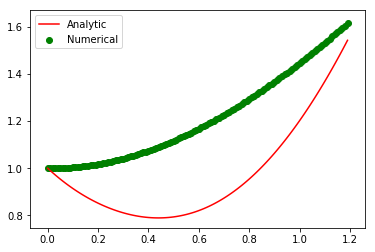

In [36]:
Xe1plot = np.arange(0,1.2, 0.01)
Xe1plot = Xe1plot.reshape((Xe1plot.shape[0], 1, 1))
Ye1 = np.array([example1_trial_solution.predict(Xe1plot[i]) for i in range(Xe1plot.shape[0])]).reshape((Xe1plot.shape[0],))
Xe1plot = Xe1plot.reshape((Xe1plot.shape[0],))
Ye12 = np.array([np.exp(-0.5*Xe1plot[i]**2)/(1+Xe1plot[i]+Xe1plot[i]**3) + Xe1plot[i]**2 for i in range(Xe1plot.shape[0])])
plt.scatter(Xe1plot, Ye1, c='g', label='Numerical')
plt.plot(Xe1plot, Ye12, c='r', label='Analytic')
plt.legend()
plt.show()